## Heston Prices over Strike & Spot 
Recreates the Streamlit app logic with fixed parameters: call and put prices computed on a grid 
of strike values (K) and spot values (S₀) using the Heston model.

In [1]:
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go

PHI_MAX = 200.0
PHI_STEPS = 2001

def heston_probability(S0, K, T, r, params, Pnum):
    phi = np.linspace(1e-5, PHI_MAX, PHI_STEPS)
    u = 0.5 if Pnum == 1 else -0.5
    kappa, theta, sigma, rho, v0 = params['kappa'], params['theta'], params['sigma'], params['rho'], params['v0']
    b = kappa - rho * sigma if Pnum == 1 else kappa
    a = kappa * theta
    x = math.log(S0)
    d = np.sqrt((rho * sigma * 1j * phi - b) ** 2 - sigma ** 2 * (2 * u * 1j * phi - phi ** 2))
    g = (b - rho * sigma * 1j * phi + d) / (b - rho * sigma * 1j * phi - d)
    exp_dt = np.exp(-d * T)
    log_term = np.log((1.0 - g * exp_dt) / (1.0 - g))
    C = r * 1j * phi * T + (a / (sigma ** 2)) * ((b - rho * sigma * 1j * phi + d) * T - 2.0 * log_term)
    D = ((b - rho * sigma * 1j * phi + d) / (sigma ** 2)) * ((1.0 - exp_dt) / (1.0 - g * exp_dt))
    integrand = np.real(np.exp(C + D * v0 + 1j * phi * (x - math.log(K))) / (1j * phi))
    h = phi[1] - phi[0]
    integral = h / 3.0 * (integrand[0] + integrand[-1] + 4.0 * np.sum(integrand[1:-1:2]) + 2.0 * np.sum(integrand[2:-2:2]))
    return 0.5 + (1.0 / math.pi) * integral

def heston_call_price(S0, K, T, r, params):
    P1 = heston_probability(S0, K, T, r, params, 1)
    P2 = heston_probability(S0, K, T, r, params, 2)
    return S0 * P1 - K * math.exp(-r * T) * P2

def heston_put_price(S0, K, T, r, params):
    call = heston_call_price(S0, K, T, r, params)
    return call - S0 + K * math.exp(-r * T)

def price_grid(spots, strikes, maturity, params, rate):
    call_prices = np.zeros((len(spots), len(strikes)))
    put_prices = np.zeros_like(call_prices)
    for i, S0 in enumerate(spots):
        for j, K in enumerate(strikes):
            call_prices[i, j] = round(heston_call_price(S0, K, maturity, rate, params), 2)
            put_prices[i, j] = round(heston_put_price(S0, K, maturity, rate, params), 2)
    return call_prices, put_prices

def plot_heatmap(values, strikes, spots, title):
    fig = go.Figure(
        data=go.Heatmap(
            z=values,
            x=np.round(strikes, 2),
            y=np.round(spots, 2),
            colorscale='Viridis',
            colorbar=dict(title=title)
        )
    )
    fig.update_layout(
        title=title,
        xaxis_title='Strike K',
        yaxis_title='Spot S₀',
    )
    return fig


/home/salok1/miniconda/envs/americanOption/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4) 
  from scipy.stats import gaussian_kde 

In [2]:
# Fixed inputs (formerly sliders) 
ref_spot = 100.0 
risk_free_rate = 0.02 
maturity = 1.0 
strike_grid = np.linspace(0.8 * ref_spot, 1.2 * ref_spot, 10) 
spot_grid = np.linspace(0.8 * ref_spot, 1.2 * ref_spot, 10) 
heston_params = { 
    'kappa': 2.0, 
    'theta': 0.04, 
    'sigma': 0.5, 
    'rho': -0.7, 
    'v0': 0.04 
} 

,Reference spot,Rate,Maturity T,Strike range,Spot range,κ,θ,σ,ρ,v₀
0,100.0,0.02,1.0,80.00 → 120.00 (10 pts),80.00 → 120.00 (10 pts),2.0,0.04,0.5,-0.7,0.04


/tmp/ipykernel_31935/1300394059.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown 
  fig_call.show() 
/tmp/ipykernel_31935/1300394059.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown 
  fig_put.show() 

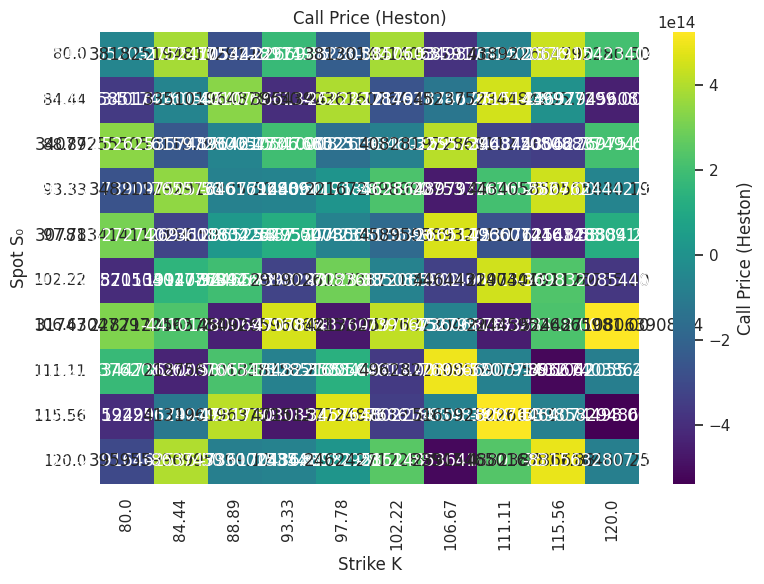

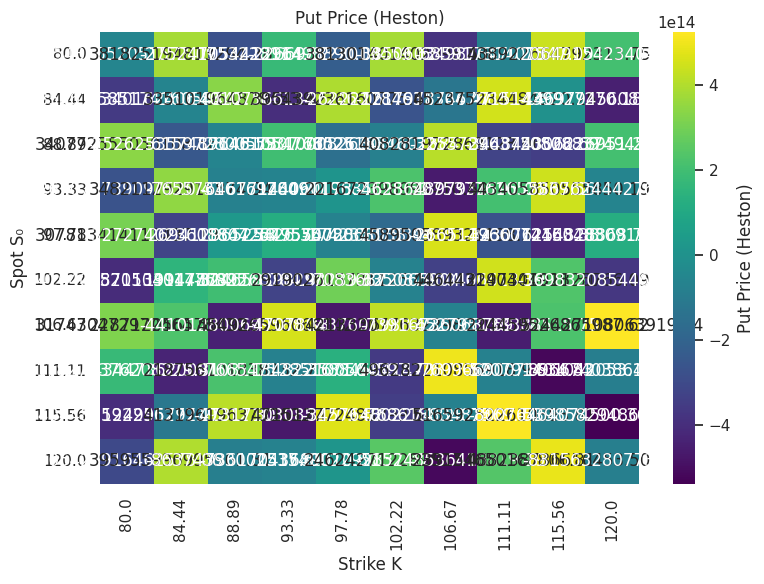

In [3]:
call_grid, put_grid = price_grid(spot_grid, strike_grid, maturity, heston_params, risk_free_rate) 
summary = pd.DataFrame({ 
    'Reference spot': [ref_spot], 
    'Rate': [risk_free_rate], 
    'Maturity T': [maturity], 
    'Strike range': [f"{strike_grid[0]:.2f} → {strike_grid[-1]:.2f} ({len(strike_grid)} pts)"], 
    'Spot range': [f"{spot_grid[0]:.2f} → {spot_grid[-1]:.2f} ({len(spot_grid)} pts)"], 
    'κ': [heston_params['kappa']], 
    'θ': [heston_params['theta']], 
    'σ': [heston_params['sigma']], 
    'ρ': [heston_params['rho']], 
    'v₀': [heston_params['v0']] 
}) 
display(summary) 
fig_call = plot_heatmap(call_grid, strike_grid, spot_grid, 'Call Price (Heston)') 
fig_put = plot_heatmap(put_grid, strike_grid, spot_grid, 'Put Price (Heston)') 
fig_call.show() 
fig_put.show() 